KeyboardInterrupt: 

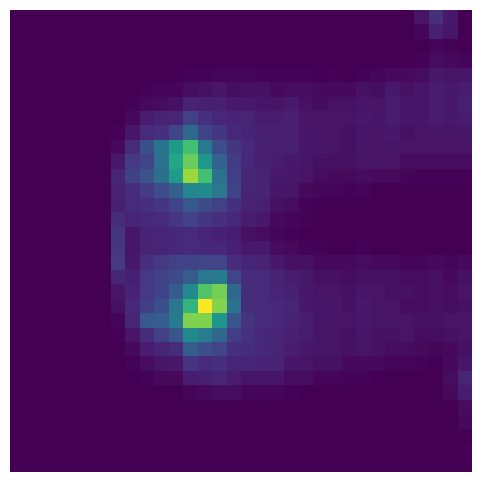

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the CSV file
file_path = "soren.csv"  # Ensure this path is correct
data = pd.read_csv(file_path)

# Drop unnecessary columns
data.drop(['Frame', 'Timestamp', 'Average Pressure (mmHg)', 'Minimum Pressure (mmHg)', 
           'Maximum Pressure (mmHg)', 'Standard Pressure Deviation (mmHg)', 
           'Median Pressure (mmHg)', 'Contact Area (m²)', 'Total Area (m²)', 
           'Estimated Force (N)', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis=1, inplace=True)

# Remove rows with all zero values
data = data[(data != 0).any(axis=1)]

# Create a directory to save the images
output_folder = "images_32x32"
os.makedirs(output_folder, exist_ok=True)

# Get the number of rows after filtering
num_rows = data.shape[0]

# Loop through each row in the dataset and save it as a 32x32 image
for i in range(num_rows):
    # Reshape the data into a 32x32 grid
    grid_data = data.iloc[i].values.reshape(32, 32)
    
    # Create a plot without axis
    plt.figure(figsize=(6, 6))
    plt.imshow(grid_data, cmap='viridis', interpolation='none')
    plt.axis('off')  # Remove axis
    
    # Save the image in the output folder
    image_filename = os.path.join(output_folder, f"pressure_image_{i+1}.png")
    plt.savefig(image_filename, bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Saved {num_rows} images in the '{output_folder}' folder after removing rows with all zero values.")


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the CSV file
file_path = "soren.csv"  # Ensure this path is correct
data = pd.read_csv(file_path)

# Drop unnecessary columns
data.drop(['Frame', 'Timestamp', 'Average Pressure (mmHg)', 'Minimum Pressure (mmHg)', 
           'Maximum Pressure (mmHg)', 'Standard Pressure Deviation (mmHg)', 
           'Median Pressure (mmHg)', 'Contact Area (m²)', 'Total Area (m²)', 
           'Estimated Force (N)', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis=1, inplace=True)

# Remove rows with all zero values
data = data[(data != 0).any(axis=1)]

# Create a directory to save the 7x7 images
output_folder_7x7 = "images_5x5"
os.makedirs(output_folder_7x7, exist_ok=True)

# Get the number of rows after filtering
num_rows = data.shape[0]

# Loop through each row in the dataset and save it as a 7x7 image
for i in range(num_rows):
    # Reshape the data into a 32x32 grid
    grid_data = data.iloc[i].values.reshape(32, 32)
    
    # # Select the values to form a 7x7 grid starting from (2, 2) and taking every 4th square
    #selected_indices = [(2 + j * 4, 2 + k * 4) for j in range(7) for k in range(7)]
    #reduced_grid_data = np.array([[grid_data[x, y] for x, y in selected_indices[j*7:(j+1)*7]] for j in range(7)])
    indices = np.linspace(1, 32, 7, dtype=int)  # This gives edge points and middle points

    # Select only the 5 middle points (2nd to 6th)
    selected_indices = [(indices[j], indices[k]) for j in range(1, 6) for k in range(1, 6)]

    # Create the reduced grid by picking only the selected points
    reduced_grid_data = np.array([[grid_data[x, y] for x, y in selected_indices[j*5:(j+1)*5]] for j in range(5)])
    # Create a plot without axis
    plt.figure(figsize=(4, 4))
    plt.imshow(reduced_grid_data, cmap='viridis', interpolation='none')
    plt.axis('off')  # Remove axis
    
    # Save the image in the output folder
    image_filename_7x7 = os.path.join(output_folder_7x7, f"pressure_image_5x5_{i+1}.png")
    plt.savefig(image_filename_7x7, bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Saved {num_rows} 5x5 images in the '{output_folder_7x7}' folder after processing the original data.")


Saved 510 5x5 images in the 'images_5x5' folder after processing the original data.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Prepare Data
def prepare_data(folder_path, image_size=(32, 32)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            img = plt.imread(os.path.join(folder_path, filename))
            # Ensure the image has 3 channels
            if img.shape[-1] == 4:  # Check for alpha channel
                img = img[..., :3]  # Discard the alpha channel
            img = transforms.ToTensor()(img)
            img = transforms.Resize(image_size)(img)  # Resize to 32x32
            images.append(img)
    return torch.stack(images)

# Paths
folder_5x5 = 'images_5x5'
folder_32x32 = 'images_32x32'
save_models_folder = 'saved_models'
os.makedirs(save_models_folder, exist_ok=True)

# Load Data
low_res_images = prepare_data(folder_5x5)
high_res_images = prepare_data(folder_32x32)

# Model Setup
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    for i in range(len(low_res_images)):
        low_res = low_res_images[i].unsqueeze(0)  # Add batch dimension
        high_res = high_res_images[i].unsqueeze(0)

        # Create labels to match the output of the discriminator
        real_label = torch.ones((1, 1, 4, 4))  # Real label (change size to [1, 1, 4, 4])
        fake_label = torch.zeros((1, 1, 4, 4))  # Fake label (change size to [1, 1, 4, 4])

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(high_res)
        d_loss_real = criterion(outputs, real_label)
        d_loss_real.backward()

        fake_image = generator(low_res)
        outputs = discriminator(fake_image.detach())
        d_loss_fake = criterion(outputs, fake_label)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_image)
        g_loss = criterion(outputs, real_label)
        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}')
    
    # Save the generator and discriminator models
    torch.save(generator.state_dict(), os.path.join(save_models_folder, 'generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(save_models_folder, 'discriminator.pth'))




NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Updated Testing Function for a specific image (image 155)
def test_model_on_image(generator, low_res_images, high_res_images, image_index=155):
    generator.eval()

    with torch.no_grad():
        # Get the low-res and high-res images for the specified index
        low_res = low_res_images[image_index].unsqueeze(0)
        fake_image = generator(low_res).squeeze().cpu().numpy()
        real_image = high_res_images[image_index].squeeze().cpu().numpy()
        low_res_image = low_res.squeeze().cpu().numpy()

        # If the images have 3 channels, convert them to grayscale by averaging the channels
        if low_res_image.ndim == 3:
            low_res_image = low_res_image.mean(axis=0)  # Convert to grayscale
        if fake_image.ndim == 3:
            fake_image = fake_image.mean(axis=0)  # Convert to grayscale
        if real_image.ndim == 3:
            real_image = real_image.mean(axis=0)  # Convert to grayscale

        # Calculate PSNR and RMSE
        psnr_value = psnr(real_image, fake_image)
        rmse_value = np.sqrt(mse(real_image, fake_image))

        print(f'PSNR for image {image_index}: {psnr_value:.2f}')
        print(f'RMSE for image {image_index}: {rmse_value:.4f}')

        # Plot the low-res, real high-res, and generated high-res images
        plt.figure(figsize=(12, 4))

        # Low-res image
        plt.subplot(1, 3, 1)
        plt.imshow(low_res_image, cmap='viridis', interpolation='none')
        plt.title(f'Low-Res Image (5x5)\nImage {image_index}')
        plt.axis('off')

        # Real high-res image
        plt.subplot(1, 3, 2)
        plt.imshow(real_image, cmap='viridis', interpolation='none')
        plt.title(f'Real High-Res Image (32x32)\nImage {image_index}')
        plt.axis('off')

        # Generated high-res image
        plt.subplot(1, 3, 3)
        plt.imshow(fake_image, cmap='viridis', interpolation='none')
        plt.title(f'Generated High-Res Image (32x32)\nImage {image_index}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Load the trained generator
generator.load_state_dict(torch.load(os.path.join(save_models_folder, 'generator.pth')))

# Test the model on image 155
test_model_on_image(generator, low_res_images, high_res_images, image_index=155)


NameError: name 'generator' is not defined

In [7]:
from pykrige.ok import OrdinaryKriging
import numpy as np

# Function to perform kriging on an image and interpolate it to a desired resolution
def kriging_interpolation(image, new_size):
    # Get the current size of the image
    current_size = image.shape

    # Create grid points for the current image size
    x_current = np.linspace(0, current_size[0] - 1, current_size[0])
    y_current = np.linspace(0, current_size[1] - 1, current_size[1])
    xx_current, yy_current = np.meshgrid(x_current, y_current)

    # Flatten the grid and image data
    points = np.vstack((xx_current.flatten(), yy_current.flatten())).T
    values = image.flatten()

    # Create new grid points for the target size
    x_new = np.linspace(0, current_size[0] - 1, new_size[0])
    y_new = np.linspace(0, current_size[1] - 1, new_size[1])
    xx_new, yy_new = np.meshgrid(x_new, y_new)

    # Perform kriging interpolation
    krig = OrdinaryKriging(xx_current.flatten(), yy_current.flatten(), values, variogram_model='linear')
    interpolated_image, _ = krig.execute('grid', x_new, y_new)

    return interpolated_image.T  # Transpose to match the original image orientation

# Updated Testing Function with Kriging interpolation for specific image (image 155)
def test_model_on_image_with_kriging(generator, low_res_images, high_res_images, image_index=155):
    generator.eval()

    with torch.no_grad():
        # Get the low-res and high-res images for the specified index
        low_res = low_res_images[image_index].unsqueeze(0)
        fake_image = generator(low_res).squeeze().cpu().numpy()
        real_image = high_res_images[image_index].squeeze().cpu().numpy()
        low_res_image = low_res.squeeze().cpu().numpy()

        # If the images have 3 channels, convert them to grayscale by averaging the channels
        if low_res_image.ndim == 3:
            low_res_image = low_res_image.mean(axis=0)  # Convert to grayscale
        if fake_image.ndim == 3:
            fake_image = fake_image.mean(axis=0)  # Convert to grayscale
        if real_image.ndim == 3:
            real_image = real_image.mean(axis=0)  # Convert to grayscale

        # Perform kriging on the low-res image to interpolate it to 64x64
        low_res_kriged = kriging_interpolation(low_res_image, (64, 64))

        # Perform kriging on the high-res images to interpolate to 256x256
        fake_image_kriged = kriging_interpolation(fake_image, (256, 256))
        real_image_kriged = kriging_interpolation(real_image, (256, 256))

        # Calculate PSNR and RMSE between the kriged real image and generated image
        psnr_value = psnr(real_image_kriged, fake_image_kriged)
        rmse_value = np.sqrt(mse(real_image_kriged, fake_image_kriged))

        print(f'PSNR for image {image_index} (Kriged): {psnr_value:.2f}')
        print(f'RMSE for image {image_index} (Kriged): {rmse_value:.4f}')

        # Plot the kriged low-res, real high-res, and generated high-res images
        plt.figure(figsize=(15, 5))

        # Kriged low-res image
        plt.subplot(1, 3, 1)
        plt.imshow(low_res_kriged, cmap='viridis', interpolation='none')
        plt.title(f'Low-Res Image (5x5 Kriged to 64x64)\nImage {image_index}')
        plt.axis('off')

        # Kriged real high-res image
        plt.subplot(1, 3, 2)
        plt.imshow(real_image_kriged, cmap='viridis', interpolation='none')
        plt.title(f'Real High-Res Image (32x32 Kriged to 256x256)\nImage {image_index}')
        plt.axis('off')

        # Kriged generated high-res image
        plt.subplot(1, 3, 3)
        plt.imshow(fake_image_kriged, cmap='viridis', interpolation='none')
        plt.title(f'Generated High-Res Image (32x32 Kriged to 256x256)\nImage {image_index}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Test the model on image 155 with kriging interpolation
test_model_on_image_with_kriging(generator, low_res_images, high_res_images, image_index=155)


ModuleNotFoundError: No module named 'pykrige'